![](https://www.securitymagazine.com/ext/resources/images/healthcare-banner.jpg?1607104673)

# Introduction

Predicting healthcare costs for individuals using accurate prediction models is important for various stakeholders beyond health insurers, and for various purposes. A few notable benefits of accurately predicting healthcare costs for insurance companies are determining fair and competitive premium rates, personalizing insurance plans, and optimizing resource allocation.

The dataset contains demographic and health information and healthcare cost of 1,338 patients. This notebook aims to find out how healthcare costs are driven by these variables by visualizing their relationships, and developing models to predict healthcare costs.


**Table of content:**
1. Data Preparation
2. Exploratory Data Analysis
3. Predictions using Polynomial Regression

# 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_palette('magma')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
df = pd.read_csv('/kaggle/input/healthcare-insurance/insurance.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
# Check for duplicates and drop them if any
print('Number of duplicates: ',df.duplicated().sum())
if df.duplicated().sum()>0:
    df = df.drop(df[df.duplicated()==1].index, axis=0)
print('Removed duplicates.')

Number of duplicates:  1
Removed duplicates.


In [3]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
# Truncate BMI and charges
df['bmi'] = np.trunc(10 * df['bmi']) / 10
df['charges'] = np.trunc(100 * df['charges']) / 100
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.7,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.8,0,no,northwest,3866.85


___

# 2. Exploratory Data Analysis

## Categorical Variables - Distribution and Correlation

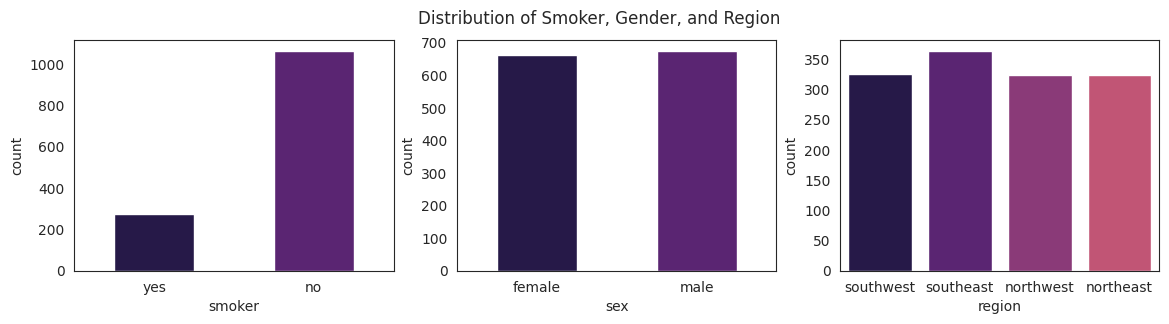

In [5]:
f, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(14,3))

sns.countplot(df,x='smoker', ax=ax_1, width=0.5)
sns.countplot(df,x='sex', ax=ax_2, width=0.5)
sns.countplot(df,x='region', ax=ax_3, width=0.8)

plt.suptitle('Distribution of Smoker, Gender, and Region', fontsize = 12)
plt.show()

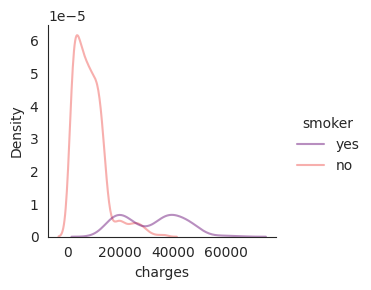

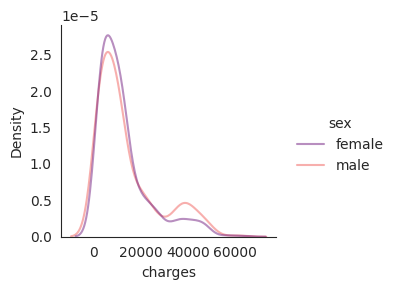

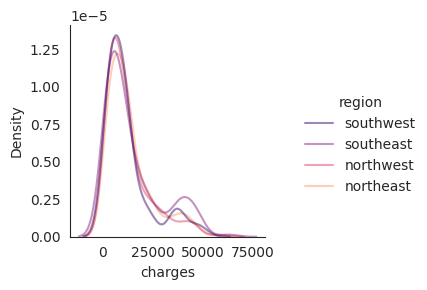

In [6]:
sns.displot(x="charges", hue="smoker", kind='kde',
            alpha=.5, palette="magma", height=3,
            data=df)

sns.displot(x="charges", hue="sex", kind='kde',
            alpha=.5, palette="magma", height=3,
            data=df)

sns.displot(x="charges", hue="region", kind='kde',
            alpha=.5, palette="magma", height=3,
            data=df)
plt.show()

- Smoking status has an impact on Charges, while Region and Sex do not.

## Numerical Variables - Distribution and Correlation

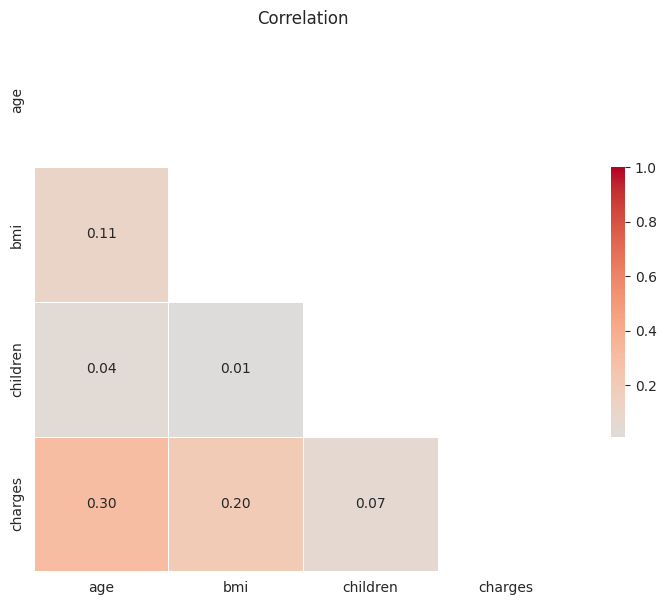

In [7]:
# Visualization of correlations using a heatmap
num_cols = df.select_dtypes(include=["float64", "int64"])
corr = num_cols.corr(method='pearson',)

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation')
plt.show()

* Age and BMI have a higher correlation with Charges. 

## Multivariate Analysis

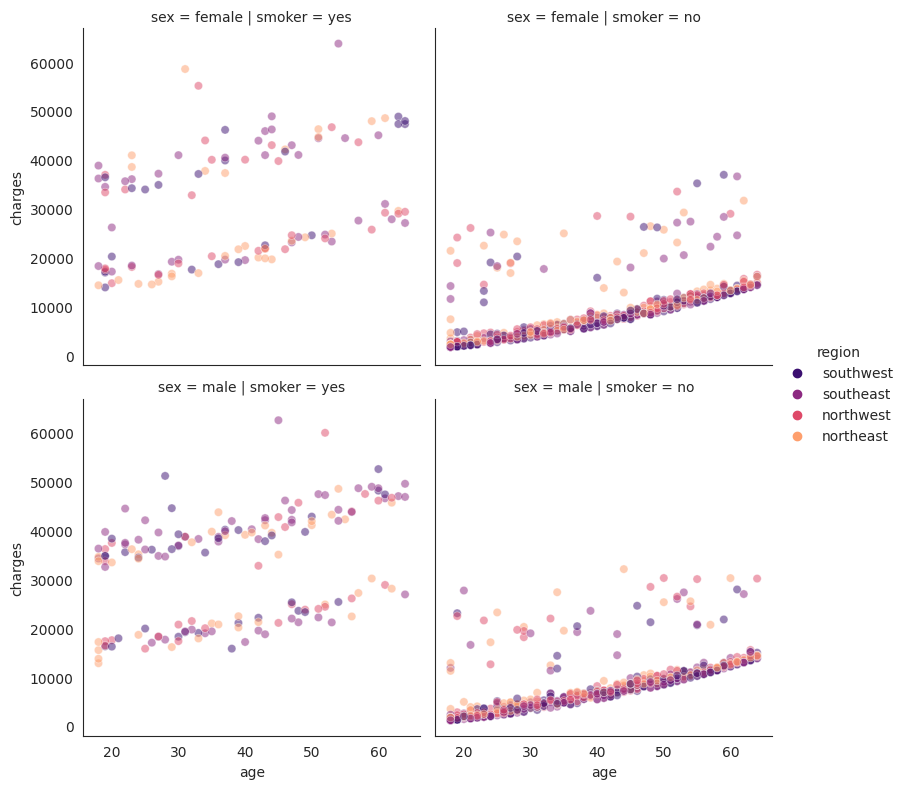

In [8]:
sns.relplot(data=df,x='age',y='charges',
           hue='region',row='sex', col='smoker',
           alpha=0.5, palette='magma', height=4)
plt.show()

* This chart again shows that Age and Smoking affects Charges.
* It is indifferent which region patients live in.

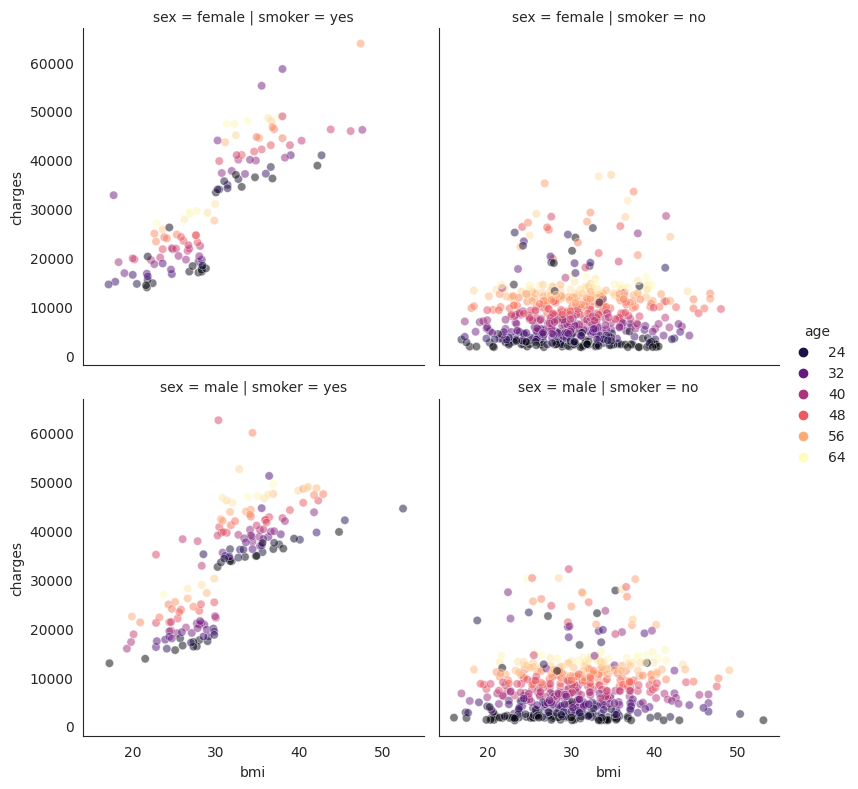

In [9]:
sns.relplot(data=df,x='bmi',y='charges',
           hue='age',row='sex', col='smoker',
           alpha=0.5, palette='magma', height=4)
plt.show()

Smoking and BMI seem to have complement effect. 
* For smokers, higher BMI leads to higher Charges.
* For non-smokers, Charges stay relatively low for all levels of BMI.

## Summary of insight
- Smoking affects healthcare costs, with smokers have higher healthcare costs than non-smokers.
- Among smokers, people with higher BMI incur higher healthcare costs.
- Age affects healthcare costs, with older people have higher costs than younger people.
- People with more children consist of mainly non-smokers. The causal relationship between the number of children and smoking status, or vice versa, cannot be determined through this dataset.
- Location and gender do not significantly affect healthcare costs.

The above findings are good suggestions for choosing independent variables in a healthcare cost prediciton model. Particularly, we can expect that **Smoking status, Age and BMI play an important role** in predicting healthcare costs.

___

# 3. Predictions using Polynomial Regression Models

We will train models to predict Charges based on Smoker, Age and BMI.

In [10]:
# Define independent and dependent variables
df.replace({'smoker': {'yes': 1, 'no': 0}}, inplace=True)
x = df[['smoker', 'age', 'bmi']].values
y = np.array(df['charges'])

# Create training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
model_MLR = LinearRegression().fit(x_train, y_train)
y_pred_MLR = model_MLR.predict(x_test)

r_sq = model_MLR.score(x, y)
print(f"Coefficient of determination: {r_sq}")
print(f"Intercept: {model_MLR.intercept_}")
print(f"Coefficients: {model_MLR.coef_}")

Coefficient of determination: 0.7470281763587638
Intercept: -10769.654425041617
Coefficients: [23702.26154321   250.1284211    304.13776941]


Model economic interpretation:
* A person who smokes will incur \$23,702 higher cost compared to someone who does not smoke (with the same BMI, at the same age).
* For every one year older, one will have to pay \$250 more.
* For every one point of BMI higher, one will have to pay \$304 more.

The Linear Regression model is not very accurate because it can **only explain 75% of the cases**, as illustrated by $R^2 = 0.747$. This could be because we have not account for the relationship among the features, particularly between Smoking and BMI. As such, we can try fitting a quadratic regression model.

## Quadratic Polynomial Regression 

In [12]:
from sklearn.preprocessing import PolynomialFeatures
x_train_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_train)
model_PR = LinearRegression().fit(x_train_poly, y_train)

x_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
r_sq2 = model_PR.score(x_poly, y)
print(f"Coefficient of determination: {r_sq2}")
print(f"Intercept: {model_PR.intercept_}")
print(f"Coefficients: {model_PR.coef_}")

Coefficient of determination: 0.8384596551762704
Intercept: -6044.03137971318
Coefficients: [-1.05745401e+04  6.60928705e+01  5.21729101e+02 -1.05745401e+04
  1.95138161e+01  1.44168187e+03  1.78542459e+00  1.53447523e+00
 -9.35711839e+00]


$R^2$ increased from 75% to 84%, showing a higher prediction power.

## Cubic Polynomial Regression

In [13]:
from sklearn.preprocessing import PolynomialFeatures
x_train_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x_train)
model_PR3 = LinearRegression().fit(x_train_poly, y_train)

x_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x)
r_sq3 = model_PR3.score(x_poly, y)
print(f"Coefficient of determination: {r_sq3}")
print(f"Intercept: {model_PR3.intercept_}")
print(f"Coefficients: {model_PR3.coef_}")

Coefficient of determination: 0.8410189397596138
Intercept: 25609.667306455973
Coefficients: [-8.82017925e+03  1.44747747e+02 -2.69938606e+03 -8.82017925e+03
 -1.51725305e+01  9.31280521e+02  1.86820724e+00 -1.78902617e+00
  9.34367872e+01 -8.82017925e+03 -1.51725305e+01  9.31280521e+02
 -2.29772160e+00  7.35459474e+00 -1.07627356e+01 -7.96756180e-03
  4.11040424e-02 -4.27396058e-02 -1.00382747e+00]


Using a cubic polynomial model only improved $R^2$ from 83.8% to 84.1% while it is costly to implement (in terms of computing resources) and harder to explain to non-technical stakeholders if the number of features increases. 

Therefore, we will choose **the Quadratic model as the final winner.**

# Conclusion

Through EDA, we learned that Age, Smoker and BMI are the three most influential variables in predicting healthcare cost. This is consistent with ordinary observations in real life.

The quadratic polynomial model is the best among three trained models. Because there is correlation between Smoker and BMI and the quadratic regression model takes into account this relationship, it is more powerful than the linear regression model for prediction purposes. Additionally, the quadratic model is simpler than the cubic model, making it more cost-effective.

Future improvements can possibly be seen by using machine learning models, or by feature engineering.




Thank you for reading!